In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import to_categorical

# Supress WARNING and INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read Data

In [2]:
#load data
data = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt",sep = "\t")
data2 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt",sep = "\t")
data3 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt",sep = "\t")
data4 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt",sep = "\t")

In [3]:
total_data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)
print(data.shape)
print(total_data.shape)

(4484, 12)
(19370, 12)


In [4]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [5]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


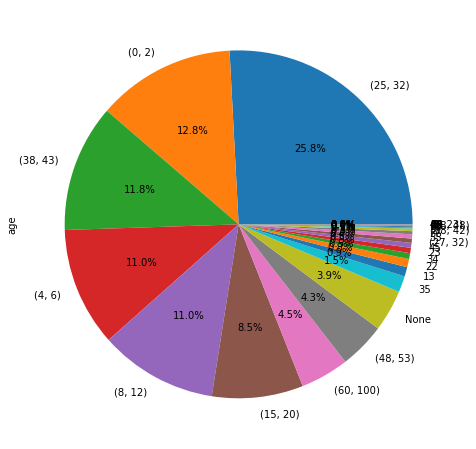

In [6]:
#pie_graph
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

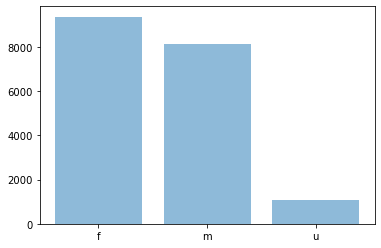

In [7]:
#bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
plt.show()

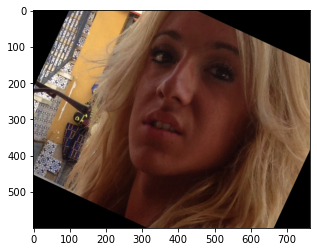

In [8]:
path = "AdienceBenchmarkGenderAndAgeClassification/faces/"+total_data.user_id.loc[0]+"/coarse_tilt_aligned_face."+str(total_data.face_id.loc[0])+"."+total_data.original_image.loc[0]
img = load_img(path)
plt.imshow(img)
plt.show()

In [9]:
total_data.gender.value_counts()

f    9372
m    8120
u    1099
Name: gender, dtype: int64

In [10]:
df = total_data[['age', 'gender']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
dtypes: object(2)
memory usage: 302.8+ KB


In [11]:
img_path = []
for row in total_data.iterrows():
    path = "AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [12]:
df.head()

,age,gender,img_path
0,"(25, 32)",f,AdienceBenchmarkGenderAndAgeClassification/fac...
1,"(25, 32)",m,AdienceBenchmarkGenderAndAgeClassification/fac...
2,"(25, 32)",f,AdienceBenchmarkGenderAndAgeClassification/fac...
3,"(25, 32)",m,AdienceBenchmarkGenderAndAgeClassification/fac...
4,"(25, 32)",m,AdienceBenchmarkGenderAndAgeClassification/fac...


In [13]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [14]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   img_path  17452 non-null  object
dtypes: object(3)
memory usage: 545.4+ KB


In [15]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,img_path
0,4,0,AdienceBenchmarkGenderAndAgeClassification/fac...
1,4,1,AdienceBenchmarkGenderAndAgeClassification/fac...
2,4,0,AdienceBenchmarkGenderAndAgeClassification/fac...
3,4,1,AdienceBenchmarkGenderAndAgeClassification/fac...
4,4,1,AdienceBenchmarkGenderAndAgeClassification/fac...


## Gender-Only model

In [16]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
y = to_categorical(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [17]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


In [18]:
model = Sequential()
model.add(Conv2D(input_shape=(227, 227, 3), filters=96, kernel_size=(7, 7), strides=4, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=2, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
layer_normalization (LayerNo (None, 28, 28, 96)        192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 14, 14, 256)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       5

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=32, epochs=5, validation_data=(test_images, y_test), callbacks=[callback])

Epoch 1/5
382/382 [==============================] - 11s 28ms/step - loss: 1.0175 - accuracy: 0.5350 - val_loss: 0.6932 - val_accuracy: 0.5241
Epoch 2/5
382/382 [==============================] - 10s 27ms/step - loss: 0.6903 - accuracy: 0.5393 - val_loss: 0.6930 - val_accuracy: 0.5241
Epoch 3/5
382/382 [==============================] - 10s 27ms/step - loss: 0.6902 - accuracy: 0.5393 - val_loss: 0.6928 - val_accuracy: 0.5241
Epoch 4/5
382/382 [==============================] - 10s 27ms/step - loss: 0.6902 - accuracy: 0.5393 - val_loss: 0.6930 - val_accuracy: 0.5241
Epoch 5/5
382/382 [==============================] - 10s 27ms/step - loss: 0.6903 - accuracy: 0.5393 - val_loss: 0.6925 - val_accuracy: 0.5241


In [21]:
# model.save('gender_model.h5')

In [22]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 2s - loss: 0.6925 - accuracy: 0.5241
0.5240641832351685


## Age-only Model

In [23]:
X = unbiased_data[['img_path']]
y = unbiased_data[['age']]
y = to_categorical(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [24]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


In [25]:
model = Sequential()
model.add(Conv2D(input_shape=(227, 227, 3), filters=96, kernel_size=(7, 7), strides=4, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=8, activation='softmax'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
layer_normalization_3 (Layer (None, 28, 28, 96)        192       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
layer_normalization_4 (Layer (None, 14, 14, 256)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 256)      

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=32, epochs=5, validation_data=(test_images, y_test), callbacks=[callback])

Epoch 1/5
382/382 [==============================] - 10s 27ms/step - loss: 2.1653 - accuracy: 0.2886 - val_loss: 1.9215 - val_accuracy: 0.2976
Epoch 2/5
382/382 [==============================] - 10s 26ms/step - loss: 1.9232 - accuracy: 0.3014 - val_loss: 1.9207 - val_accuracy: 0.2976
Epoch 3/5
382/382 [==============================] - 10s 26ms/step - loss: 1.9229 - accuracy: 0.3014 - val_loss: 1.9210 - val_accuracy: 0.2976
Epoch 4/5
382/382 [==============================] - 10s 26ms/step - loss: 1.9223 - accuracy: 0.3014 - val_loss: 1.9206 - val_accuracy: 0.2976
Epoch 5/5
382/382 [==============================] - 10s 26ms/step - loss: 1.9235 - accuracy: 0.3014 - val_loss: 1.9222 - val_accuracy: 0.2976


In [28]:
# model.save('age_model.h5')

In [29]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 1s - loss: 1.9222 - accuracy: 0.2976
0.2975553870201111
